In [1]:
import sys
import os

# 方法 1：使用 os.getcwd() 获取当前工作目录
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, ".."))
print(f"add project root \"{project_root}\" to system path:")
sys.path.append(project_root)

add project root "/mnt/nas-data/work-data/programs/2025-03-14-fine-tune-clip" to system path:


初始化logger

In [2]:
from clip_tuner.utils import Logger

logger = Logger(log_dir="../logs/", log_file="train_demo.log", file_mode="w")
print(f"created logger at \"{logger.log_path}\"")

created logger at "/mnt/nas-data/work-data/programs/2025-03-14-fine-tune-clip/logs/train_demo.log"


构建Data Manager，管理数据集，随后加载一个数据集 "office-31" - "webcam"

In [ ]:
from datasets import load_dataset
from clip_tuner.data import DataManager, get_train_transforms, get_val_transforms

data_manager = DataManager(logger=None)  # build data manager without logger
for dataset in data_manager.list_datasets():
    print(dataset)

source_info = data_manager.get_dataset("office-31", "webcam")
target_info = data_manager.get_dataset("office-31", "amazon")

source_dataset = load_dataset(source_info.data_dir)["train"]
target_dataset = load_dataset(target_info.data_dir)["train"]

source_dataset.set_transform(get_train_transforms())
target_dataset.set_transform(get_val_transforms())

source_dataset, target_dataset

/home/wyh/anaconda3/envs/pytorch-nightly/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetInfo(dataset_name=office-31, domain_name=amazon, data_dir=/mnt/nas-data/work-data/datasets/images/office-31/amazon/images/, num_classes=31, class_names=['mouse', 'mobile_phone', 'printer', 'punchers', 'keyboard', 'tape_dispenser', 'bike', 'desktop_computer', 'trash_can', 'scissors', 'file_cabinet', 'projector', 'letter_tray', 'bottle', 'monitor', 'laptop_computer', 'calculator', 'phone', 'bookcase', 'ring_binder', 'headphones', 'speaker', 'desk_lamp', 'stapler', 'mug', 'pen', 'back_pack', 'desk_chair', 'ruler', 'bike_helmet', 'paper_notebook'])
DatasetInfo(dataset_name=office-31, domain_name=dslr, data_dir=/mnt/nas-data/work-data/datasets/images/office-31/dslr/images/, num_classes=31, class_names=['paper_notebook', 'ring_binder', 'pen', 'trash_can', 'mug', 'projector', 'speaker', 'bottle', 'ruler', 'bike', 'laptop_computer', 'stapler', 'bike_helmet', 'calculator', 'bookcase', 'desk_lamp', 'letter_tray', 'desktop_computer', 'monitor', 'headphones', 'mouse', 'desk_chair', 'file_ca

(Dataset({
     features: ['image', 'label'],
     num_rows: 795
 }),
 Dataset({
     features: ['image', 'label'],
     num_rows: 2817
 }))

构建Model Manager，管理模型，随后加载一个模型 "clip-vit-base-patch32"

In [4]:
from transformers import CLIPModel, CLIPTokenizer
from clip_tuner.models import ModelManager

model_manager = ModelManager()
for model_info in model_manager.list_models():
    print(model_info)
model_info = model_manager.get_model("clip-vit-base-patch32")
model = CLIPModel.from_pretrained(model_info.path)
tokenizer = CLIPTokenizer.from_pretrained(model_info.path)
model, tokenizer

Model: clip-vit-b-16-datacomp.l-s1b-b8k, Path: /mnt/nas-data/work-data/models/modelscope/hub/laion/CLIP-ViT-B-16-DataComp.L-s1B-b8K/, Config: 
Model: clip-vit-l-14-datacomp.xl-s13b-b90k, Path: /mnt/nas-data/work-data/models/modelscope/hub/laion/CLIP-ViT-L-14-DataComp.XL-s13B-b90K/, Config: 
Model: clip-vit-base-patch32, Path: /mnt/nas-data/work-data/models/modelscope/hub/thomas/clip-vit-base-patch32/, Config: 
Model: clip-vit-base-patch16, Path: /mnt/nas-data/work-data/models/modelscope/hub/openai-mirror/clip-vit-base-patch16/, Config: 


(CLIPModel(
   (text_model): CLIPTextTransformer(
     (embeddings): CLIPTextEmbeddings(
       (token_embedding): Embedding(49408, 512)
       (position_embedding): Embedding(77, 512)
     )
     (encoder): CLIPEncoder(
       (layers): ModuleList(
         (0-11): 12 x CLIPEncoderLayer(
           (self_attn): CLIPSdpaAttention(
             (k_proj): Linear(in_features=512, out_features=512, bias=True)
             (v_proj): Linear(in_features=512, out_features=512, bias=True)
             (q_proj): Linear(in_features=512, out_features=512, bias=True)
             (out_proj): Linear(in_features=512, out_features=512, bias=True)
           )
           (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
           (mlp): CLIPMLP(
             (activation_fn): QuickGELUActivation()
             (fc1): Linear(in_features=512, out_features=2048, bias=True)
             (fc2): Linear(in_features=2048, out_features=512, bias=True)
           )
           (layer_norm2): La

修改dataset，当前 dataset 的 label 字段为整数，
适配 image classification 任务，而非 zero-shot image classification

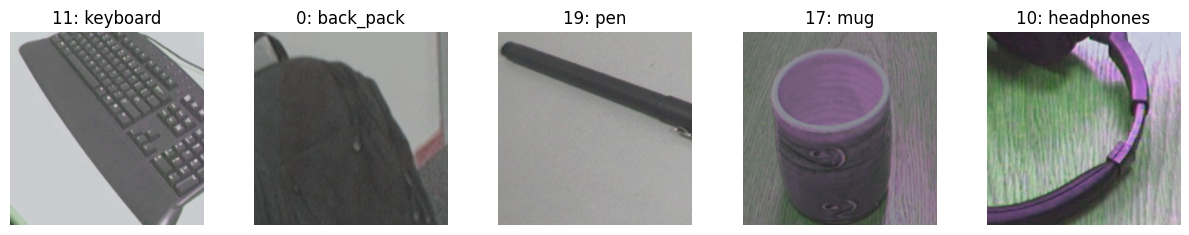

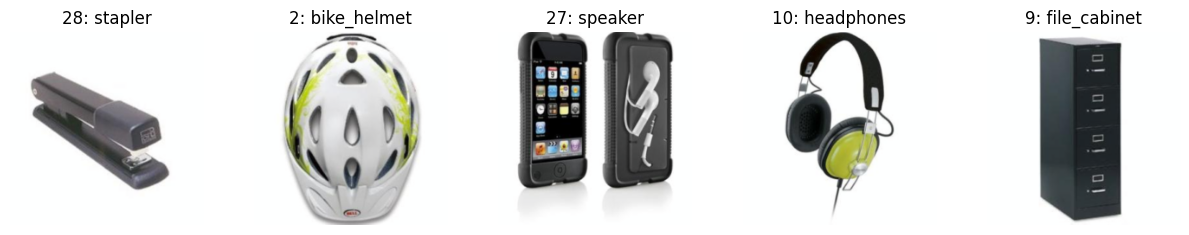

In [5]:
from clip_tuner.utils import visualize_dataset_samples

visualize_dataset_samples(source_dataset, num_samples=5)  # 带训练transform的样本
visualize_dataset_samples(target_dataset, num_samples=5)  # 验证样本

In [ ]:
import torch.nn as nn
from transformers import CLIPModel, CLIPTokenizer
from datasets import ClassLabel


class PromptLearner(nn.Module):

    def __init__(
        self,
        clip_model: CLIPModel,
        clip_tokenizer: CLIPTokenizer,
        class_label: ClassLabel,
        prompt_template: str = "a photo of a {}.",
    ):
        super().__init__()

        self.clip_model = clip_model
        self.clip_tokenizer = clip_tokenizer
        self.class_label = class_label
        self.prompt_template = prompt_template
        
        self.parameters()

    def forward(self, image, label):
        """_summary_

        Args:
            image (_type_): _description_
            label (_type_): _description_
        1. label -> prompt -> learnable prompt -> text_embedding
        2. image -> image_embedding
        Returns:
            _type_: _description_
        """
        cls = self.class_label.int2str(label)
        prompt = self.prompt_template.format(cls)
        prompt_tokens = self.clip_tokenizer(prompt, return_tensors="pt", padding=True)
        self.clip_model.text_model.embeddings.token_embedding(prompt_tokens)
        

'a photo of a cat'